# MLFlow POC

In [1]:
!python -m spacy download en_core_web_sm

2022-03-03 14:32:56.251794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 14:32:56.251815: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 8.9 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Loading packages and data

In [2]:
import re, spacy, unicodedata
import pandas as pd
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud

from sklearn import tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline

import mlflow
import mlflow.sklearn as mlsk

sns.set(rc={'figure.figsize':(20,10)})

2022-03-03 14:33:05.064491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-03 14:33:05.064517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./amazon_product_reviews_dataset.csv')
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [4]:
# selecting only reviews about Alexa
df = df[df.name == 'Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker']

#### Initiating mlflow scikit-learn autolog

In [5]:
mlflow.start_run()

<ActiveRun: >

In [6]:
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

Active run_id: 98c20fe21d2349a6bfefbe86d16a6e47


In [7]:
# mlflow.sklearn.autolog()
# I won't use autolog here because I couldn't find a way to name the models logged through autolog

#### Loading Natural Language Processing tools and aux functions

In [8]:
# Load portuguese corpus
spacy_model = spacy.load('en_core_web_sm')

# Load stopwords terms
words = []
with open('./stopwords_en.txt', 'r') as f:
    token = f.readline()
    while token:
        words.append(token.strip())
        token = f.readline()

In [9]:
def strip(text):
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub('[^a-z0-9 ]+', '', str(text).lower())
    text = re.sub(' +', ' ', text)

    document = []
    for token in spacy_model(text):
        if not token.is_punct and str(token) not in words:
            document.append(token.lemma_ if token.pos_ == 'VERB' else token.orth_)

    return ' '.join(document)

#### Initiating data processing

In [10]:
# Vectorizing reviews text

df['trusted'] = df['reviews.text'].apply(strip)

min_df = 5
max_df = 0.6
max_features = 2000
ngram = (1,3)

vectorizer = TfidfVectorizer(
        min_df = min_df,
        max_df = max_df,
        ngram_range = ngram,
        max_features = max_features
    )

pipe = Pipeline([('vectorizer', vectorizer)])
pipe.fit(df.trusted.values)
    
vectorized = pipe.transform(df.trusted.values)

In [11]:
mlsk.log_model(pipe, 'vectorizer')

ModelInfo(artifact_path='vectorizer', flavors={'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle'}}, model_uri='runs:/98c20fe21d2349a6bfefbe86d16a6e47/vectorizer', model_uuid='081051922ead4674a171cab7da275810', run_id='98c20fe21d2349a6bfefbe86d16a6e47', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-03-03 17:34:10.183414')

#### Separating train and test data

In [12]:
df['vectorized'] = vectorized.toarray().tolist()

train, test = train_test_split(df, test_size=0.33, random_state=42)
test.to_csv('test_data.csv')

#### Applying Agglomerative Clustering model

In [13]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
# Create linkage matrix and then plot the dendrogram
# create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
    else:
        current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

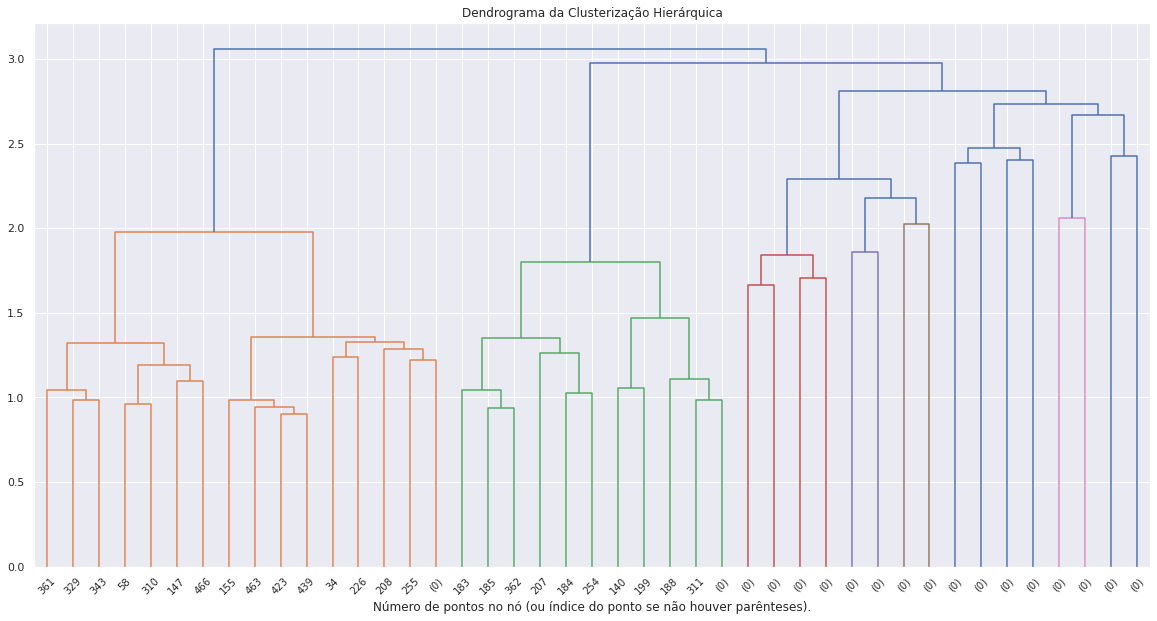

In [14]:
# clusterização com número fixo de clusters
clustering = AgglomerativeClustering(n_clusters = 4, linkage = 'ward',compute_distances=True)
clustering = clustering.fit(vectorized.toarray())
# adiciona resultado no df
df['cluster'] = list(clustering.labels_)
plt.title('Dendrograma da Clusterização Hierárquica')
# o parâmetro p indica o número de níveis que serão plotados
plot_dendrogram(clustering, truncate_mode = 'level', p = 5)
plt.xlabel("Número de pontos no nó (ou índice do ponto se não houver parênteses).")
plt.xticks(fontsize=10, rotation=45)
plt.show()

In [15]:
mlsk.log_model(clustering, 'clustering')

ModelInfo(artifact_path='clustering', flavors={'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle'}}, model_uri='runs:/98c20fe21d2349a6bfefbe86d16a6e47/clustering', model_uuid='72e0ea69900349b8a38e7f6d9a75d213', run_id='98c20fe21d2349a6bfefbe86d16a6e47', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-03-03 17:35:01.902207')

In [16]:
df.cluster.value_counts()

0    385
1    126
3     18
2     13
Name: cluster, dtype: int64

#### Clusters review:

In [17]:
df['words'] = df.trusted.str.split(' ')
df = df.sort_values('cluster')

df_subsets = []
for c in df.cluster.unique():
    df_subsets.append(df[df.cluster == c])

/home/gabriela.batista/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


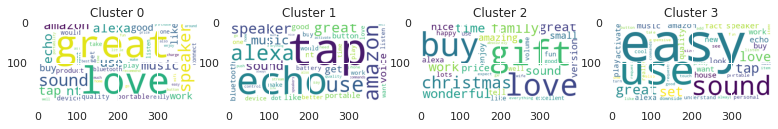

In [18]:
mw = 50

fig = pyplot.figure(figsize = (20, 15))
vocabulary = vectorizer.get_feature_names()
vocabulary.append('')

i = 0
for r in df_subsets:
    vocab_words=[]
    for words in r.words:
        vocab_words.append(np.extract([word in vocabulary for word in words], words))
    vocab_words = [item for sublist in vocab_words for item in sublist]
    cnt = Counter(vocab_words)

    wc = WordCloud(
        background_color='white',
        max_words=mw,
        relative_scaling=0.1,
        normalize_plurals=True
    )
    
    image = wc.generate_from_frequencies(cnt)

    ax = fig.add_subplot(6,6, (i + 1))
    pyplot.imshow(image)
    ax.set_title(f'Cluster {i}')
    i = i + 1

In [19]:
topn = 10

for s in df_subsets:
    values = s['reviews.text'].values
    print(f'\nCluster: {s.cluster.values[0]}')
    for v in range(topn):
        print(values[v][:150])


Cluster: 0
The tap is amazing. portable and connected to all amazon content
The whole family is using it. Music, Bluetooth speaker, questions, game times, sports scores. Love the portability.
If you want one of the most advanced alarm clocks on the market then this is your device!It works well. Calendar functions, plays radio, most podcasts
We bought to give away at a Halloween party. We own them ourselves and they are awesome
This gizmo is awesome for those who want the portability and cool things you can do with the Alexa world!
We use this speaker all the time. It's perfect. I would buy this time and time again.
Didn't know I would like it this much, but it's wonderful. I use it mostly for streaming music from Pandora. I love that I don't have to rely on anoth
Love that the Tap is portable. Drag it all around the house and outside. I'm not an audiophile, but I think the sound quality is very good except at t
No issues at all... wish it were water proof. My kids and family love it.


In [25]:
df.to_csv('train_data.csv')

#### Creating Decision Tree classificator

In [20]:
X, y = df['vectorized'], df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test = X_train.values.tolist(), X_test.values.tolist()

In [21]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [22]:
mlsk.log_model(clf, 'classifier')

ModelInfo(artifact_path='classifier', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.9.7', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle'}}, model_uri='runs:/98c20fe21d2349a6bfefbe86d16a6e47/classifier', model_uuid='5ab673418246437f91bc1040cedccc0a', run_id='98c20fe21d2349a6bfefbe86d16a6e47', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-03-03 17:35:40.674358')

#### Model Evaluation

In [23]:
predicted = clf.predict(X_test)
arr = []
print(f'{format(np.sum(predicted == y_test) / len(predicted) * 100, ".2f")}% of classification acuracy')

78.21% of classification acuracy


In [24]:
print(classification_report(y_test, predicted, labels=list(range(5))))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       125
           1       0.62      0.54      0.58        39
           2       0.83      1.00      0.91         5
           3       0.60      0.60      0.60        10
           4       0.00      0.00      0.00         0

   micro avg       0.78      0.78      0.78       179
   macro avg       0.58      0.60      0.59       179
weighted avg       0.78      0.78      0.78       179



/home/gabriela.batista/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriela.batista/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriela.batista/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gab